In [20]:
import sys, yaml, os, string, re
import pandas as pd 
import numpy as np
import polars as pl
import textdistance as td
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import seaborn as sns
import yake 
import matplotlib.pyplot as plt
import textblob
from sklearn.linear_model import LogisticRegression
from rouge_score import rouge_scorer
from strsimpy import SIFT4
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
sns.set_theme(style="whitegrid")

def get_rouge_scores(string1, string2, rouge_types=['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL'], use_stemmer=True, split_summaries=False):
    
    """
    Calculate the Rouge scores between two strings.

    Parameters:
    string1 (str): The first string.
    string2 (str): The second string.
    rouge_types (list): A list of Rouge types to calculate. Default is ['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL'].
    use_stemmer (bool): Whether to use a stemmer for word tokenization. Default is True.
    split_summaries (bool): Whether to split summaries into sentences. Default is False.

    Returns:
    dict: A dictionary containing the Rouge scores for each Rouge type.
    """

    scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer, split_summaries=split_summaries)
    scores = scorer.score(string1, string2)
    return scores



def get_sift4_dist(string1, string2):
    """
    Calculate the SIFT4 similarity between two strings.

    Parameters:
    string1 (str): The first string.
    string2 (str): The second string.

    Returns:
    float: The SIFT4 similarity score between the two strings.
    """

    sift4 = SIFT4(  )
    return sift4.distance(string1, string2)

def get_yake_keywords(x:str, n=20, dedupLim=0.3, dedupFunc='seqm', windowsSize=1, top=2):

    """
    Extracts top N keywords from the input text using the YAKE algorithm.

    Args:
        x (str): The input text.

    Returns:
        list: A list of top N keywords extracted from the input text.

    
    Example:
        text = "The quick brown fox jumps over the lazy dog"
        keywords = custom_kw_extractor.extract_keywords(text)
        print(keywords)
    """

    #yake setup
    custom_kw_extractor = yake.KeywordExtractor(lan='en'
                                                , n=n
                                                , dedupLim=dedupLim
                                                , dedupFunc=dedupFunc
                                                , windowsSize=windowsSize
                                                , top=top 
                                                )

    return ','.join([x[0] for x in custom_kw_extractor.extract_keywords(x)])



def get_data(df_url):
    """
    Retrieves data from the specified URL and returns it as a DataFrame.

    Args:
        df_url (str): The URL of the data file.

    Returns:
        DataFrame: The loaded data.

    """
    #get data 
    df = pl.read_csv(df_url,  separator='\t')
    return df

#2nd level string cleaning 
#text processing for modeling (beyond basic input text formatting)
def clean_sentence(sentence: str
                   , punctuation: str = None
                   , stemmer = None
                   , lower: bool = False
                   , stopwords = None
                   ) -> str:
    """
    Cleans a sentence by removing punctuation, converting to lowercase
    , removing stopwords, and applying stemming if specified.

    Args:
        sentence (str): The input sentence to be cleaned.
        punctuation (str, optional): A string containing the punctuation characters to be removed. Defaults to string.punctuation+"\\\\".
        stemmer (object, optional): An object implementing the stemmer interface for word stemming. Defaults to None.
        lower (bool, optional): Flag indicating whether to convert the sentence to lowercase. Defaults to False.
        stopwords (list, optional): A list of stopwords to be removed from the sentence. Defaults to None.

    Returns:
        str: The cleaned sentence.

    """
    sentence = sentence.encode('ascii',errors = 'ignore').decode()

    if punctuation is not None: 
        sentence=re.sub(f'[{punctuation}]',' ',sentence)
        sentence = re.sub(' {2,}',' ', sentence)

    #if lower 
    sentence= sentence.lower().strip() if lower else sentence.strip()
    
    #if stopwords 
    if stopwords: 
        sentence = ' '.join([word for word in sentence.split() if word not in stopwords])
    
    #if stem 
    if stemmer: 
        sentence = ' '.join([stemmer.stem(word) for word in sentence.split()])
        
    return sentence


In [9]:

#text preprocessing stuff 
PUNC =string.punctuation
STOPWORDS = list(stopwords.words('english'))
STEMMER = SnowballStemmer('english')


#location of data to evalute
df_url = 'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt'
target_col = 'entailment_judgment'
text_col1 = 'sentence_A'
text_col2 = 'sentence_B'

remove_stopwords = True
remove_punc = True
lower_text = True
stem_text = True 

algo_descriptions = {
    "td.Prefix": "Calculates the longest common prefix length between two strings.",
    "td.Postfix": "Calculates the longest common suffix length between two strings.",
    "td.Length": "Calculates the absolute difference in length between two strings.",
    "td.Cosine": "Measures the cosine similarity between two strings, which is the cosine of the angle between their vector representations.",
    "td.Jaccard": "Measures the Jaccard similarity between two strings, which is the size of the intersection divided by the size of the union of the two sets.",
    "td.Bag": "Compares two strings based on multiset theory, which allows for multiple occurrences of elements.",
    "td.Sorensen": "Measures the Sorensen-Dice coefficient between two strings, which is twice the size of the intersection divided by the sum of the sizes of the two sets.",
    "td.MongeElkan": "Applies a secondary string distance function to all pairs of substrings and averages the results.",
    "td.Overlap": "Measures the overlap coefficient between two strings, which is the size of the intersection divided by the size of the smaller set.",
    "td.Tanimoto": "Measures the Tanimoto coefficient between two strings, which is the size of the intersection divided by the size of the union of the two sets.",
    "td.Tversky": "Measures the Tversky index between two strings, which is a generalization of the Jaccard coefficient.",
    "td.Levenshtein": "Measures the Levenshtein distance between two strings, which is the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into the other.",
    "td.Hamming": "Measures the Hamming distance between two strings, which is the number of positions at which the corresponding symbols are different.",
    "td.NeedlemanWunsch": "Implements the Needleman-Wunsch algorithm, which is used in bioinformatics to align protein or nucleotide sequences.",
    "td.SmithWaterman": "Implements the Smith-Waterman algorithm, which is used in bioinformatics to perform local sequence alignment.",
    "td.Gotoh": "Implements the Gotoh algorithm, which is used in bioinformatics to perform sequence alignment with affine gap scoring.",
    "td.StrCmp95": "Implements the Jaro-Winkler string similarity measure, which is designed for comparing short strings like person names.",
    "td.MLIPNS": "Implements the Metric Longest Increasing Subsequence Pseudo-Normalized Similarity, which is a string similarity measure based on the longest increasing subsequence problem.",
    "td.ArithNCD": "Implements the Arithmetic Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.BWTRLENCD": "Implements the Burrows-Wheeler Transform Relative Lempel-Ziv Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.RLENCD": "Implements the Run-Length Encoding Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.ZLIBNCD": "Implements the Zlib Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.SqrtNCD": "Implements the Square Root Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.EntropyNCD": "Implements the Entropy Normalized Compression Distance, which is a measure of the compressibility of a string.",
    "td.MRA": "Implements the Match Rating Approach, which is a phonetic algorithm developed to assist in the matching of data in areas such as information retrieval and record linkage.",
    "td.Editex": "Implements the Editex algorithm, which is a string distance measure that takes into account phonetic similarities.",
    "td.LCSSeq": "Implements the Longest Common Subsequence Similarity, which is a measure of the longest subsequence common to two strings.",
    "td.LCSStr": "Implements the Longest Common Substring Similarity, which is a measure of the longest substring common to two strings.",
    "td.RatcliffObershelp": "Implements the Ratcliff/Obershelp pattern recognition algorithm, which measures the similarity between two strings.",
    "td.Jaro": "Implements the Jaro string similarity measure, which is designed for comparing short strings like person names.",
    "td.JaroWinkler": "Implements the Jaro-Winkler string similarity measure, which is a variant of the Jaro measure that gives more favorable ratings to strings that match from the beginning."
}


algos = [td.Prefix()
 , td.Postfix()
 , td.Length()
 , td.cosine
 , td.jaccard
 , td.Bag()
 , td.Sorensen()
 , td.MongeElkan()
 , td.Overlap()
 , td.Tanimoto()
 , td.Tversky()
 , td.levenshtein
 , td.hamming
 , td.NeedlemanWunsch()
 , td.SmithWaterman()
 , td.Gotoh()
 , td.StrCmp95()
 , td.MLIPNS()
 , td.ArithNCD()
 , td.BWTRLENCD()
 , td.RLENCD()
 , td.ZLIBNCD()
 , td.SqrtNCD()
 , td.EntropyNCD()
 , td.MRA()
 , td.Editex()
 , td.LCSSeq()
 , td.LCSStr()
 , td.RatcliffObershelp()
 , td.Jaro()
 , td.JaroWinkler()
 ]

In [16]:

#load data 
df = get_data(df_url).head(10000)

In [17]:
#clean text 
for col in [text_col1, text_col2]:
    df = df.with_columns(
        
        pl.col(col).map_elements(lambda x: clean_sentence(x
                                                        , punctuation = PUNC if remove_punc else None
                                                        , stemmer = STEMMER if stem_text else None
                                                        , lower = True if lower_text else False
                                                        , stopwords = STOPWORDS if remove_stopwords else None
                                                        ) 
                                                        , return_dtype= pl.Utf8()
                                                        ).alias(f"{col}_cleaned")
        )
    
    #extract keywords
    df = df.with_columns(
        pl.col(f"{col}_cleaned").map_elements(lambda x: get_yake_keywords(x)
                                              , return_dtype= pl.Utf8()
                                                        ).alias(f"{col}_keywords")
    )


#compute sentiment of text1 vs text2 (variance in sentiment from textblob)
df = df.with_columns(
    pl.struct([f"{text_col1}",f"{text_col2}"])\
    .map_elements(lambda x: textblob.TextBlob(x[f"{text_col1}"]
                                                ).sentiment.polarity - textblob.TextBlob(
                                                    x[f"{text_col2}"]).sentiment.polarity
                    , return_dtype= pl.Float64()
                    ).alias(f"sentiment_dif"
    ))


#compute rouge socres of text1 vs text2 (variance in sentiment from textblob)
df = df.with_columns(
    pl.struct([f"{text_col1}_keywords",f"{text_col2}_keywords"])\
    .map_elements(lambda x: textblob.TextBlob(x[f"{text_col1}_keywords"]
                                                ).sentiment.polarity - textblob.TextBlob(
                                                    x[f"{text_col2}_keywords"]).sentiment.polarity
                    , return_dtype= pl.Float64()
                    ).alias(f"sentiment_dif_kw"
    ))


#compute rouge socres of text1 vs text2 (variance in sentiment from textblob)
df = df.with_columns(
    pl.struct([f"{text_col1}",f"{text_col2}"])\
    .map_elements(lambda x: get_sift4_dist(x[f"{text_col1}"],x[f"{text_col2}"])
                    , return_dtype= pl.Float64()
                    ).alias(f"sift4_dist"
    ))
df = df.with_columns(
    pl.struct([f"{text_col1}_keywords",f"{text_col2}_keywords"])\
    .map_elements(lambda x: get_sift4_dist(x[f"{text_col1}_keywords"],x[f"{text_col2}_keywords"])
                    , return_dtype= pl.Float64()
                    ).alias(f"sift4_dist_kw"
    ))

In [18]:

#create unifired object with details on  each method
algo_dic_list = []
for idx,algo in enumerate(algos):
    algo_dic_list.append({'colname':f"td.{algo}".split('(')[0]
                          ,'func':algo
                          , 'description':algo_descriptions[f"td.{algo}".split('(')[0]]
                          })

    #compute text similarity
    df = df.with_columns(
        pl.struct([f"{text_col1}_cleaned",f"{text_col2}_cleaned"])\
        .map_elements(lambda x: algo.normalized_similarity(x[f"{text_col1}_cleaned"], x[f"{text_col2}_cleaned"])
                        , return_dtype= pl.Float64()
                        ).alias(f"{algo}".split('(')[0]
        ))
    
    
    #compute text similarity of keywords?
    df = df.with_columns(
        pl.struct([f"{text_col1}_keywords",f"{text_col2}_keywords"])\
        .map_elements(lambda x: algo.normalized_similarity(x[f"{text_col1}_keywords"]
                                                           , x[f"{text_col2}_keywords"])
                        , return_dtype= pl.Float64()
                        ).alias(f"{algo}".split('(')[0]+"_kw"
        ))
    

    
#go to pandas 
pdf = df.to_pandas()

#create rouge score columns (cheating)
pdf = pdf.assign(**dict(zip(['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL']
                      ,zip(*pdf.apply(lambda x: [x.fmeasure for x in get_rouge_scores(x['sentence_A_cleaned'], x['sentence_B_cleaned']
                                                                 , rouge_types=['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL']
                                                                 , use_stemmer=True, split_summaries=False).values()], axis=1)))))

#rouge scores for keywords
pdf = pdf.assign(**dict(zip(['rouge1_kw', 'rouge2_kw', 'rouge3_kw', 'rouge4_kw', 'rouge5_kw', 'rougeL_kw']
                      ,zip(*pdf.apply(lambda x: [x.fmeasure for x in get_rouge_scores(x['sentence_A_keywords'], x['sentence_B_keywords']
                                                                 , rouge_types=['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL']
                                                                 , use_stemmer=True, split_summaries=False).values()], axis=1)))))

#create a hard target to predict(aka these strings are being considered the same)
pdf['target'] = pdf.apply(lambda row: 1 if (row[target_col] == 'ENTAILMENT' and row['relatedness_score']>=4.5) else 0, axis=1)

###  Plot diff in similarity by target level 

/tmp/ipykernel_4208/2338834803.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diff_df = mean_sim.groupby('method').apply(lambda x: x[x['target'] == 1]['avg_keyword_sim'].mean() - x[x['target'] == 0]['avg_keyword_sim'].mean()).reset_index()
/tmp/ipykernel_4208/2338834803.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diff_df['diff_text_sim'] = mean_sim.groupby('method').apply(lambda x: x[x['targe

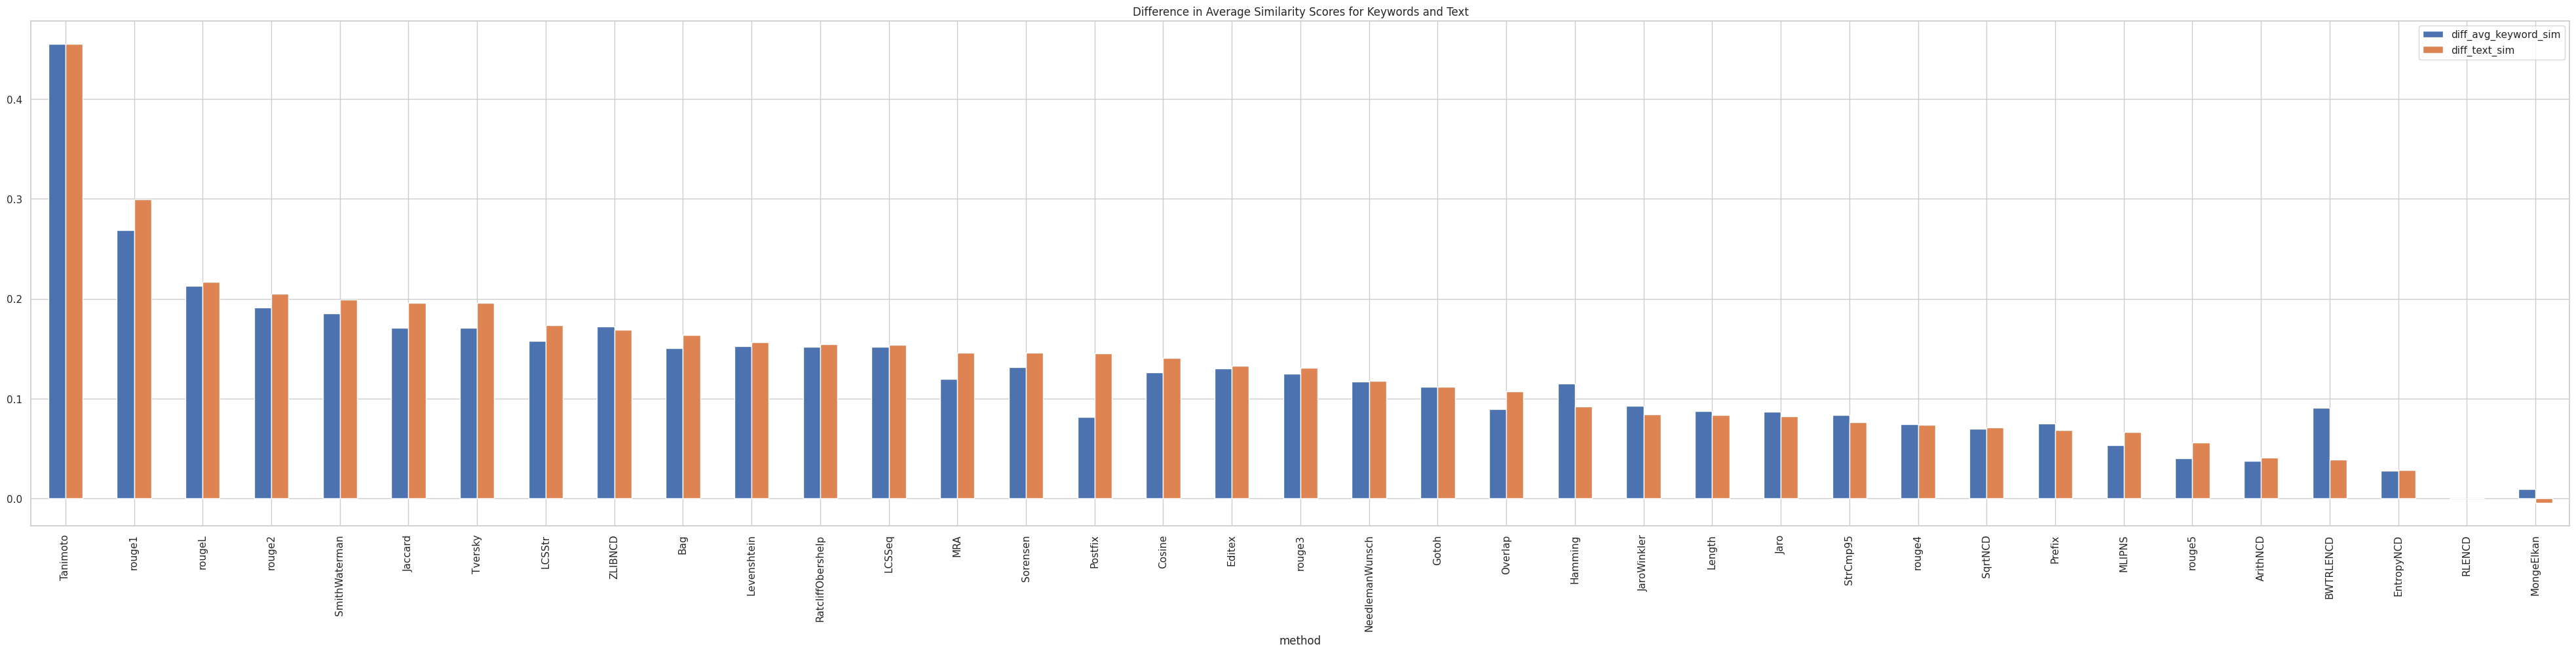

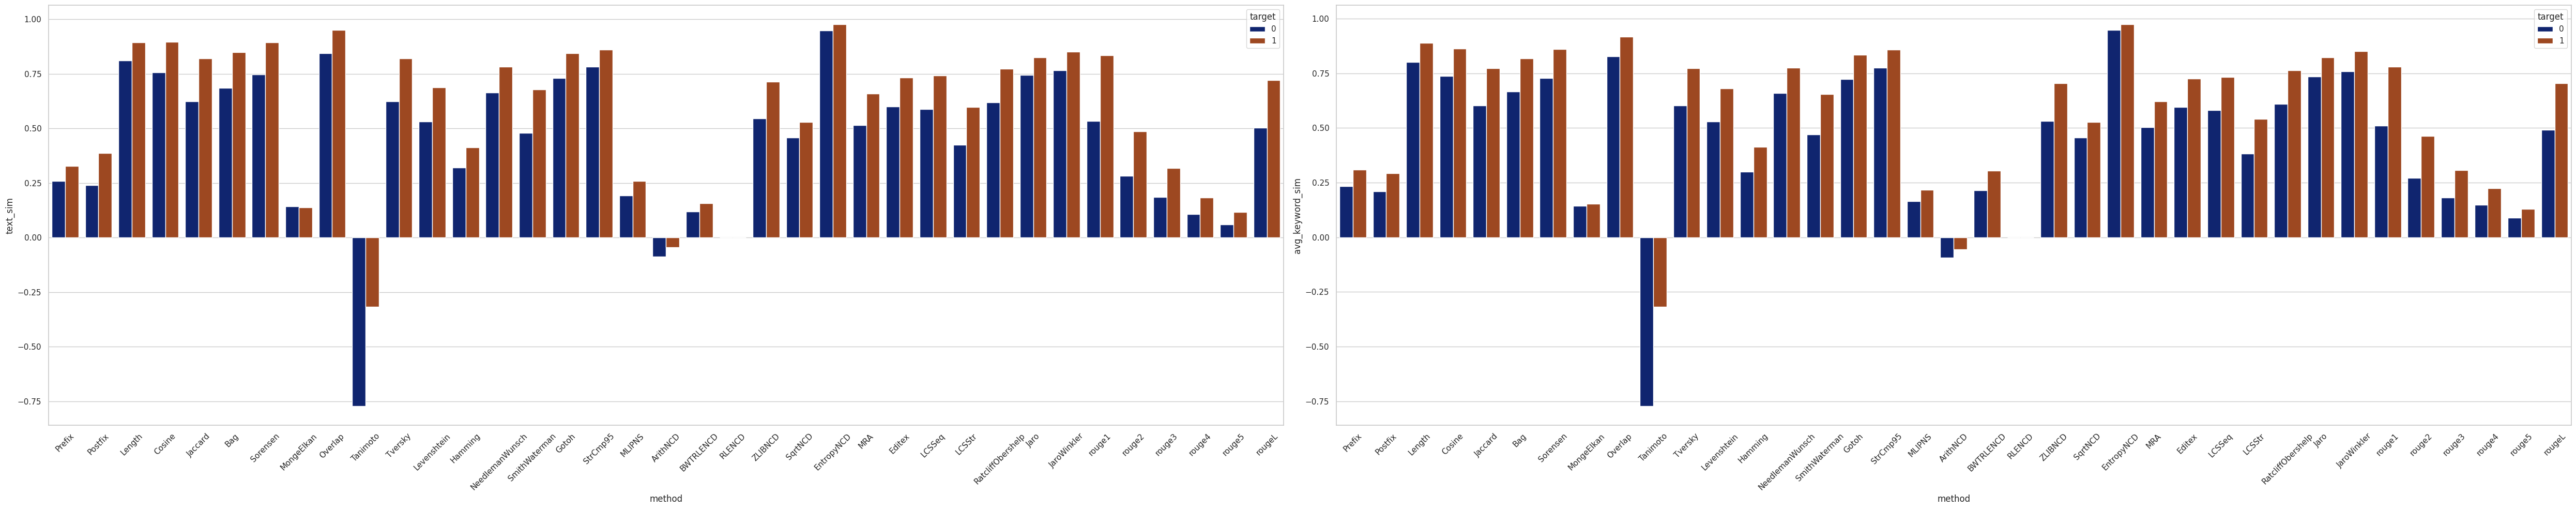

In [21]:
#replace inf for plotting 
numeric_cols = pdf.select_dtypes(include=[np.number]).columns.tolist()
inf_cols = [t[0] for t in list(zip(numeric_cols, [np.isinf(pdf[col]).values.any() for col in numeric_cols])) if t[1]==True]

for col in inf_cols: 

    #if value of non key word exists, use that
    if '_kw' in col:
        pdf[col] = pdf[f"{col}".replace('_kw','')]

#generate means
tst = []
for idx,algo in enumerate(algos+['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL']):
    _tmp =  pdf[[f"{algo}".split('(')[0]+"_kw", f"{algo}".split('(')[0], 'target']].groupby('target'
                                        , dropna=False
                                        ).mean()
    _tmp.columns = ['avg_keyword_sim','text_sim']
    _tmp['method']=f"{algo}".split('(')[0]
    tst.append(_tmp.reset_index())

#mean sims 
mean_sim = pd.concat(tst)

# Group the filtered dataframe by method and calculate the difference
diff_df = mean_sim.groupby('method').apply(lambda x: x[x['target'] == 1]['avg_keyword_sim'].mean() - x[x['target'] == 0]['avg_keyword_sim'].mean()).reset_index()
diff_df.columns = ['method', 'diff_avg_keyword_sim']

# Merge with the difference for text_sim
diff_df['diff_text_sim'] = mean_sim.groupby('method').apply(lambda x: x[x['target'] == 1]['text_sim'].mean() - x[x['target'] == 0]['text_sim'].mean()).values

# Print the resulting dataframe
diff_df.sort_values(by='diff_text_sim',ascending=False).plot(x='method'
                                                             , y=['diff_avg_keyword_sim', 'diff_text_sim']
                                                             , kind='bar', figsize=(50, 10)
                                                             , title='Difference in Average Similarity Scores for Keywords and Text')
plt.show()


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(50,10))
sns.barplot(
    data=mean_sim, 
    x="method"
    , y="text_sim"
    , hue="target"
    , errorbar="sd"
    , palette="dark"
    , ax=ax[0]
)
sns.barplot(
    data=mean_sim 
    , x="method"
    , y="avg_keyword_sim"
    , hue="target"
    , errorbar="sd"
    , palette="dark"
    , ax=ax[1]

)
# Rotate x-axis labels on ax[0]
ax[0].tick_params(axis='x', rotation=45)

# Rotate x-axis labels on ax[1]
ax[1].tick_params(axis='x', rotation=45)
fig.tight_layout()

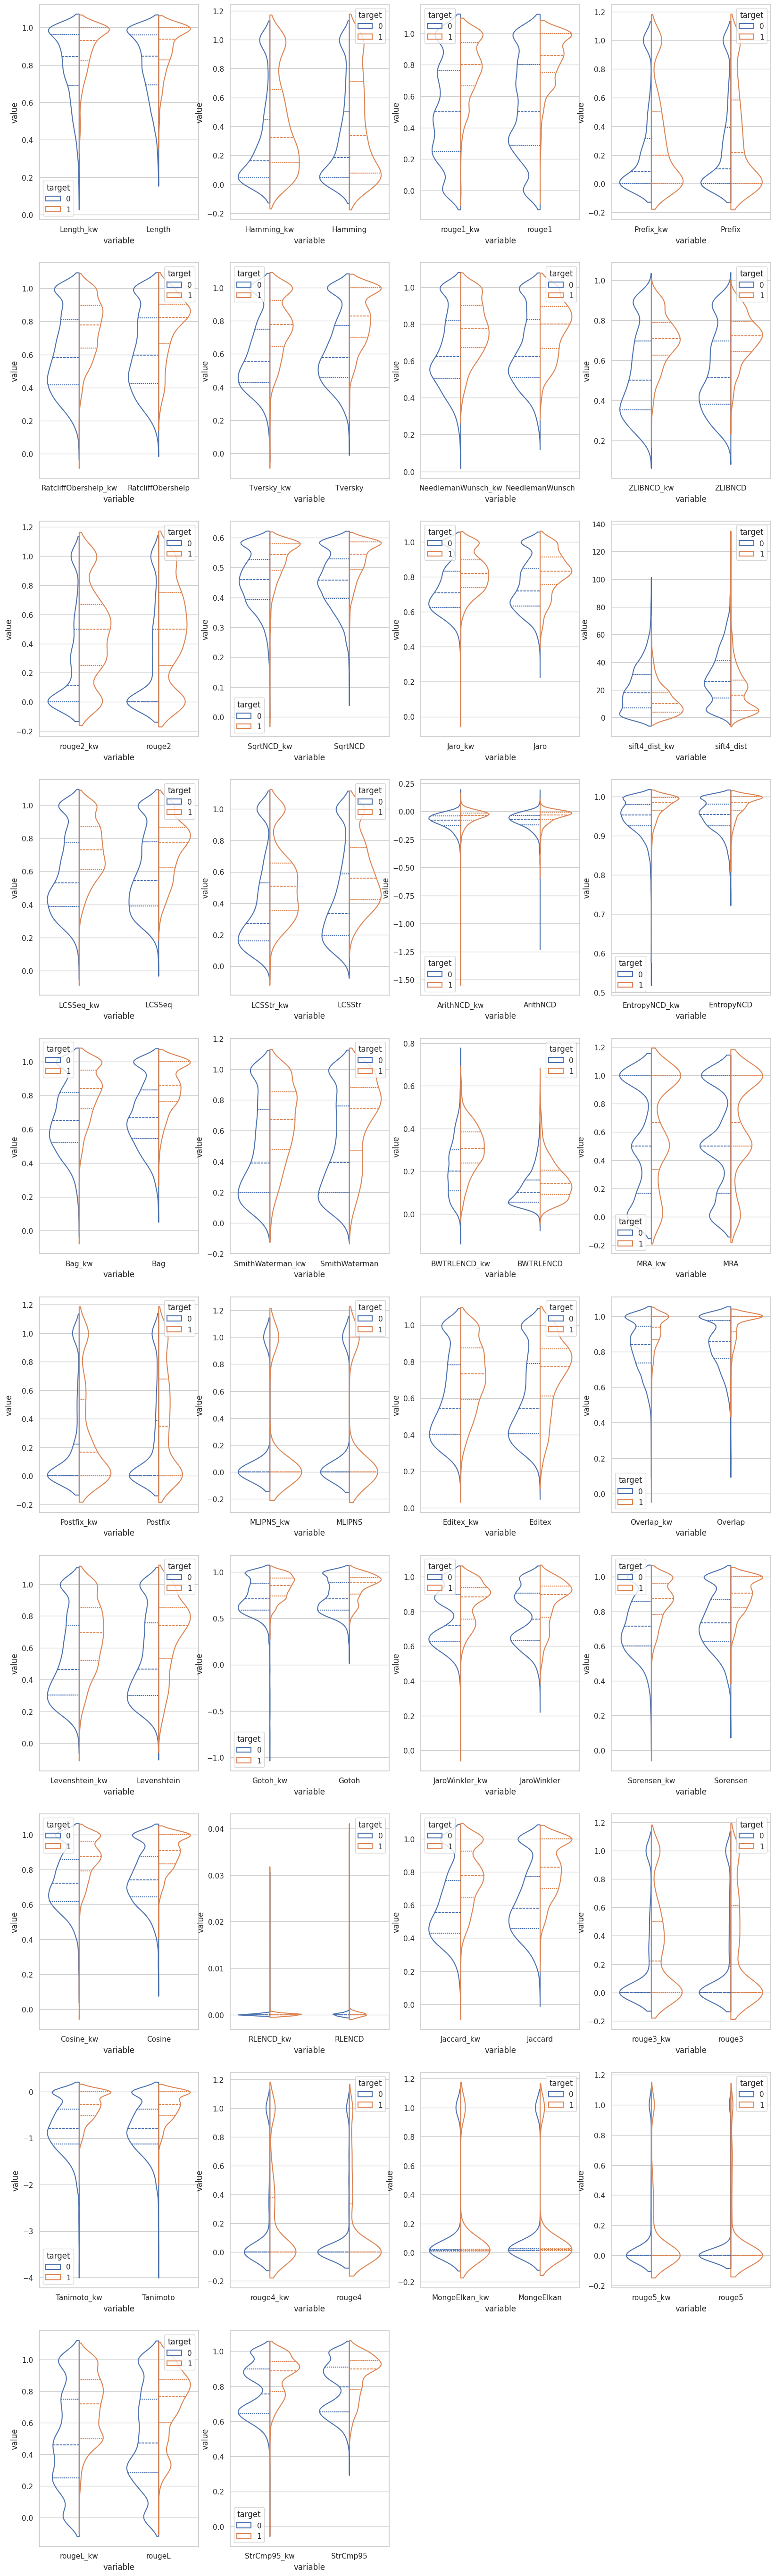

In [22]:
vars2plot = list(set(algos+['rouge1', 'rouge2', 'rouge3', 'rouge4', 'rouge5', 'rougeL','sift4_dist']))
number_of_subplots = len(vars2plot)
Tot = number_of_subplots
Cols = 4

# Compute Rows required
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
fig = plt.figure(1,figsize=(20,70))

tst = []
for idx,algo in enumerate(vars2plot):
    _plt_df = pdf[[f"{algo}".split('(')[0]+"_kw", f"{algo}".split('(')[0], 'target']]
    
    #fig,ax = plt.subplots(1,2, figsize=(10,5))
    
    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows,Cols,Position[idx])
    
    _plt_df.melt(id_vars='target').pipe((sns.violinplot,'data')
                                        , x='variable', y='value'
                                        , hue='target', split=True
                                        , fill=False, inner='quart'
                                        , ax=ax)

plt.show()

Baseline accuracy on test data: 0.87


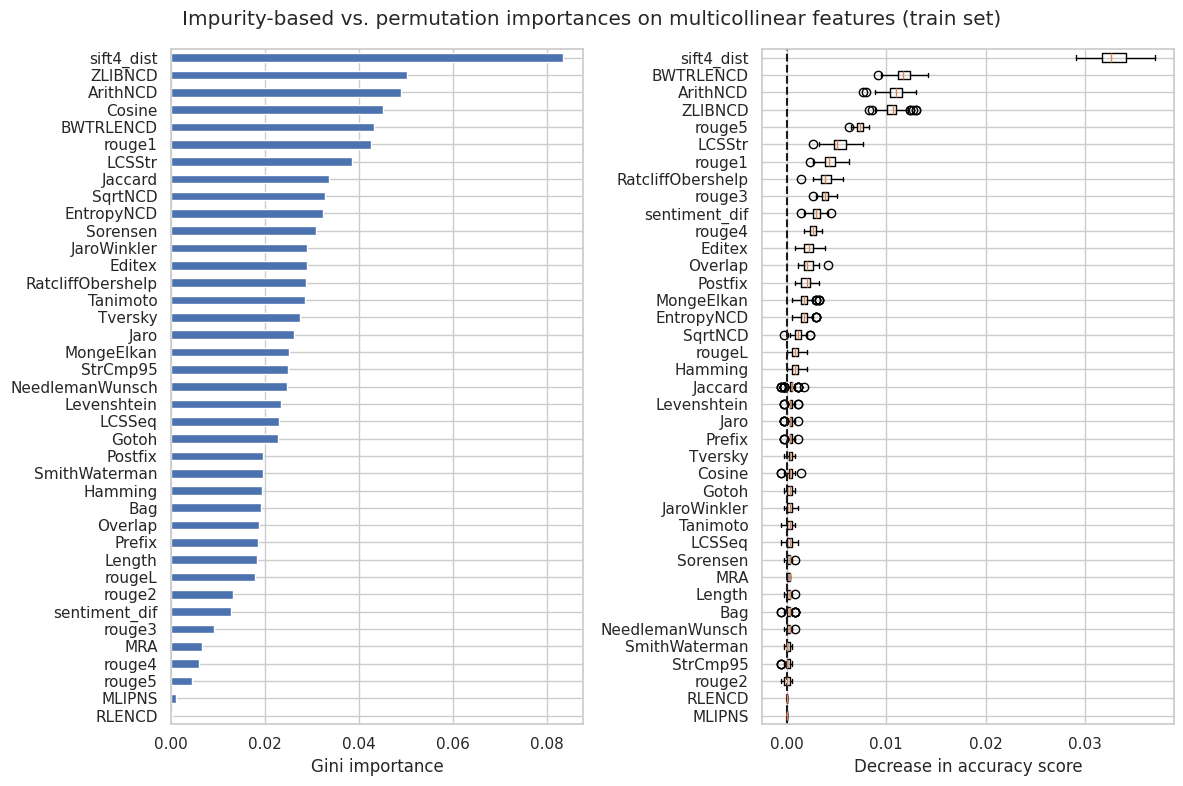

In [23]:
vars2plot = list(set([f"{x}".split('(')[0] for x in vars2plot] + ['sentiment_dif']))

def plot_permutation_importance(clf, X, y, ax, n_repeats = 100,n_jobs=4):
    result = permutation_importance(clf, X, y, n_repeats=n_repeats , random_state=42, n_jobs=n_jobs)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

X = pdf[vars2plot]
y = pdf['target']
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")


mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

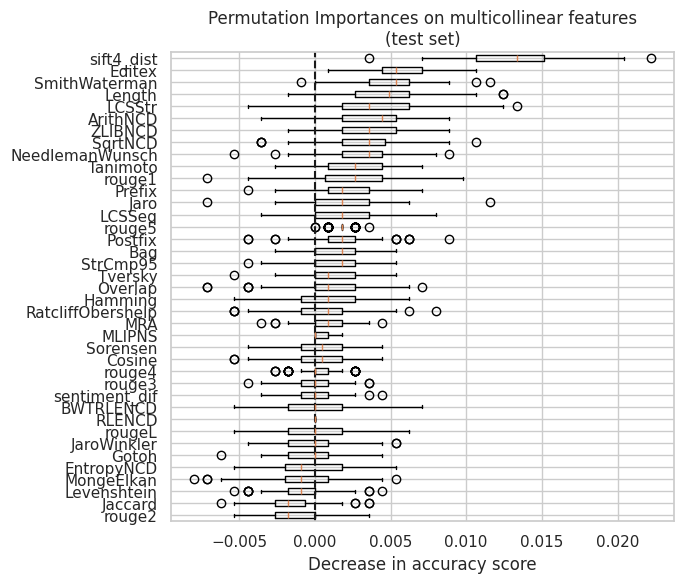

In [24]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf, X_test, y_test, ax,n_repeats=100, n_jobs = 8)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

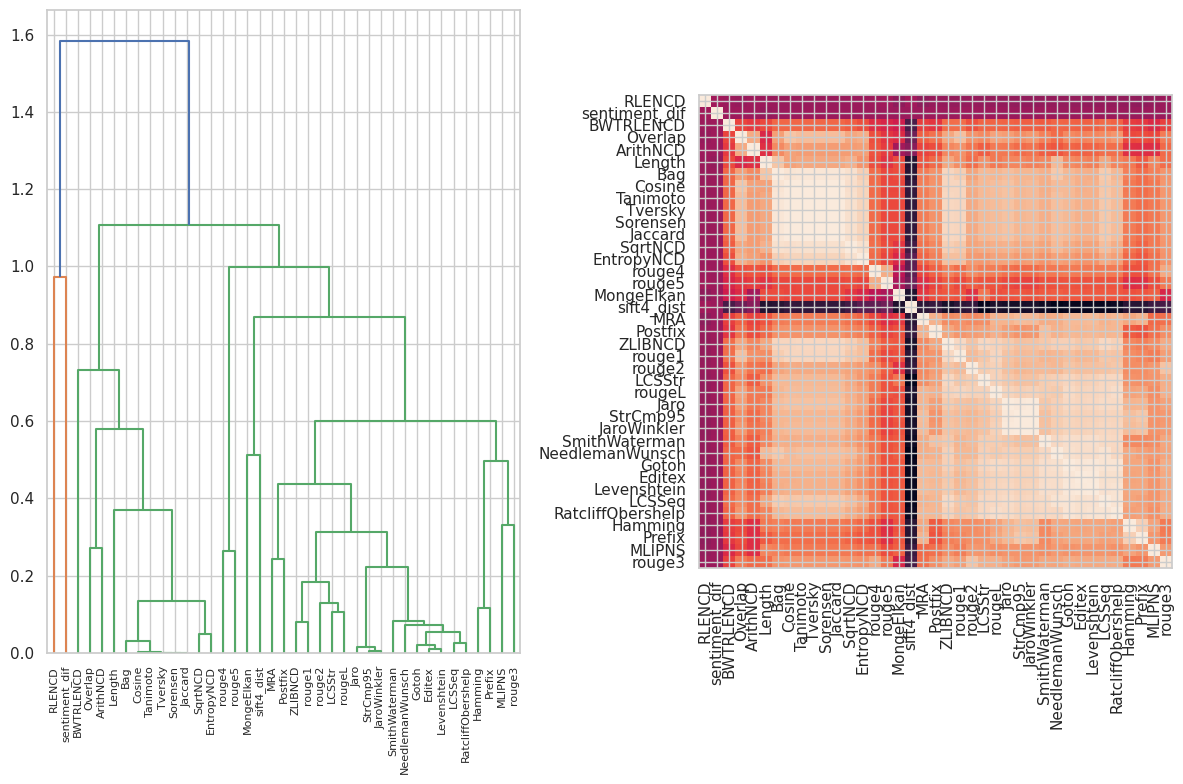

In [25]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [34]:
from collections import defaultdict
cluster_distance_threshold = .2
cluster_ids = hierarchy.fcluster(dist_linkage,cluster_distance_threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)
clf_sel.feature_names_in_

Baseline accuracy on test data with features removed: 0.86


array(['Overlap', 'MRA', 'LCSSeq', 'ZLIBNCD', 'MLIPNS', 'MongeElkan',
       'Sorensen', 'StrCmp95', 'sift4_dist', 'Hamming', 'Length',
       'BWTRLENCD', 'RLENCD', 'Postfix', 'rouge3', 'sentiment_dif',
       'rouge4', 'rouge5', 'ArithNCD'], dtype=object)

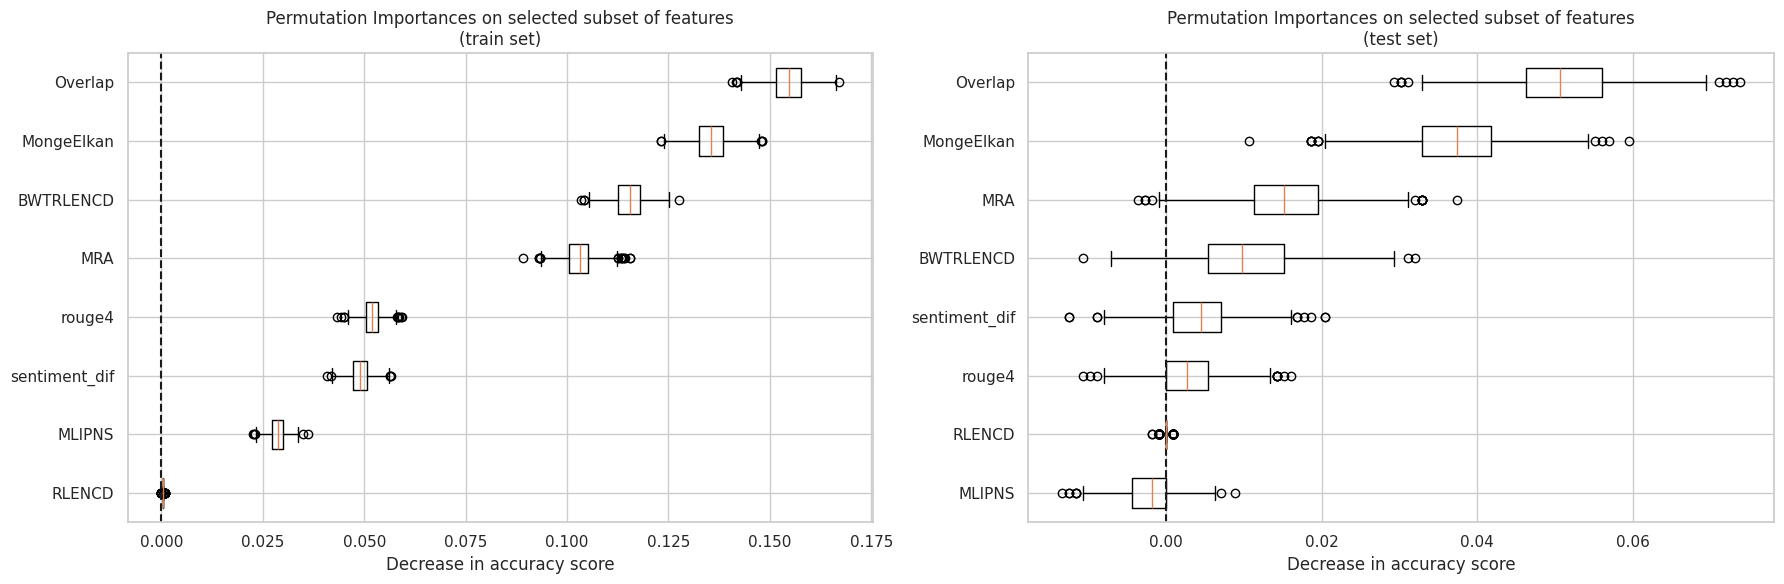

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 6))
plot_permutation_importance(clf_sel, X_train_sel, y_train, ax[0],n_repeats=1000, n_jobs=8)
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax[1],n_repeats=1000, n_jobs=8)
ax[0].set_title("Permutation Importances on selected subset of features\n(train set)")
ax[1].set_title("Permutation Importances on selected subset of features\n(test set)")
ax[0].set_xlabel("Decrease in accuracy score")
ax[1].set_xlabel("Decrease in accuracy score")
ax[0].figure.tight_layout()
ax[1].figure.tight_layout()
plt.show()

In [36]:
final_features = ['Jaccard','LCSStr','sift4_dist','sentiment_dif', 'Overlap','MongeElkan','MRA']

X_train_sel = X_train[final_features]
X_test_sel = X_test[final_features]

clf_sel = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

#confusion matrix 
y_preds_tr = clf_sel.predict(X_train_sel)
y_preds_tst = clf_sel.predict(X_test_sel)

from sklearn.metrics import confusion_matrix
display(confusion_matrix(y_train, y_preds_tr,normalize='all'))
display(confusion_matrix(y_test, y_preds_tst,normalize='all'))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds_tst))

Baseline accuracy on test data with features removed: 0.85


array([[0.78459259, 0.01748148],
       [0.12444444, 0.07348148]])

array([[0.80177778, 0.024     ],
       [0.12266667, 0.05155556]])

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       929
           1       0.68      0.30      0.41       196

    accuracy                           0.85      1125
   macro avg       0.77      0.63      0.66      1125
weighted avg       0.84      0.85      0.83      1125



In [41]:
clf_sel = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
clf_sel.fit(X, y)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X, y):.2}"
)

#confusion matrix 
y_preds = clf_sel.predict_proba(X)
pdf['y_pred_prob'] = [x[1] for x in y_preds]

Baseline accuracy on test data with features removed: 0.85


In [43]:
#review the output (we provide LOB with rank ordered list of most similar items)
pdf.sort_values(by='y_pred_prob',ascending=False)[['sentence_A','sentence_B','target','y_pred_prob']].head(100)

,sentence_A,sentence_B,target,y_pred_prob
2389,A man is playing a flute,A flute is being played by a man,1,0.841036
2000,A man is playing a flute,A flute is being played by a man,1,0.841036
2123,A guitar is being played by a kid,A kid is playing guitar,1,0.840219
2543,The guitar is being played by a kid,A kid is playing the guitar,1,0.839954
2346,The trumpet is being played by a man,A man is playing the trumpet,1,0.839744
...,...,...,...,...
1404,A lemon is being squeezed by a woman,A woman is squeezing a lemon,1,0.707286
2139,A person is slicing an onion,An onion is being sliced by a person,1,0.704986
2683,"A person with a back pack, who is topless, is in front of a pile of rocks and clouds are in the background",A topless person with a back pack is in front of a pile of rocks and clouds are in the background,1,0.703465
1184,A person is cutting a capsicum into pieces,A capsicum is being cut into pieces by a person,1,0.702512
